# Introduction

Special teams is a component of American football that is not explored nearly as extensively as offense and defense. While the frequency of the decision to punt is declining slightly, punts remain an integral part of the game. They offer the returning team the opportunity gain additional yardage and better field position and the kicking team an opportunity to back their opponents deep into their own territory. The job of the punt returner is to try and gain as many yards as possible with the help of their teammates' blocking and is generally what spectators pay attention to. However, the role is unique relative to others since it is the only position where a significant part of their role on the field is to make a decision mid-play about whether to end the play on the spot or attempt to run with the ball. There are three main types of decisions on punt returns:

1.  Return the punt

2.  Call a fair catch

3.  Let it drop

    i.  Downed  
    ii. Touchback
    iii. Ball bounced/landed out of bounds (not included due to time constraints)

A majority of punt plays are not actually returned (as shown in the graph below), which is why it is important to evaluate not just returns, but all other punt play results. In this analysis, I leverage tracking data to evaluate punt returners while adjusting for this decision-making component and quantify the decisions themselves.

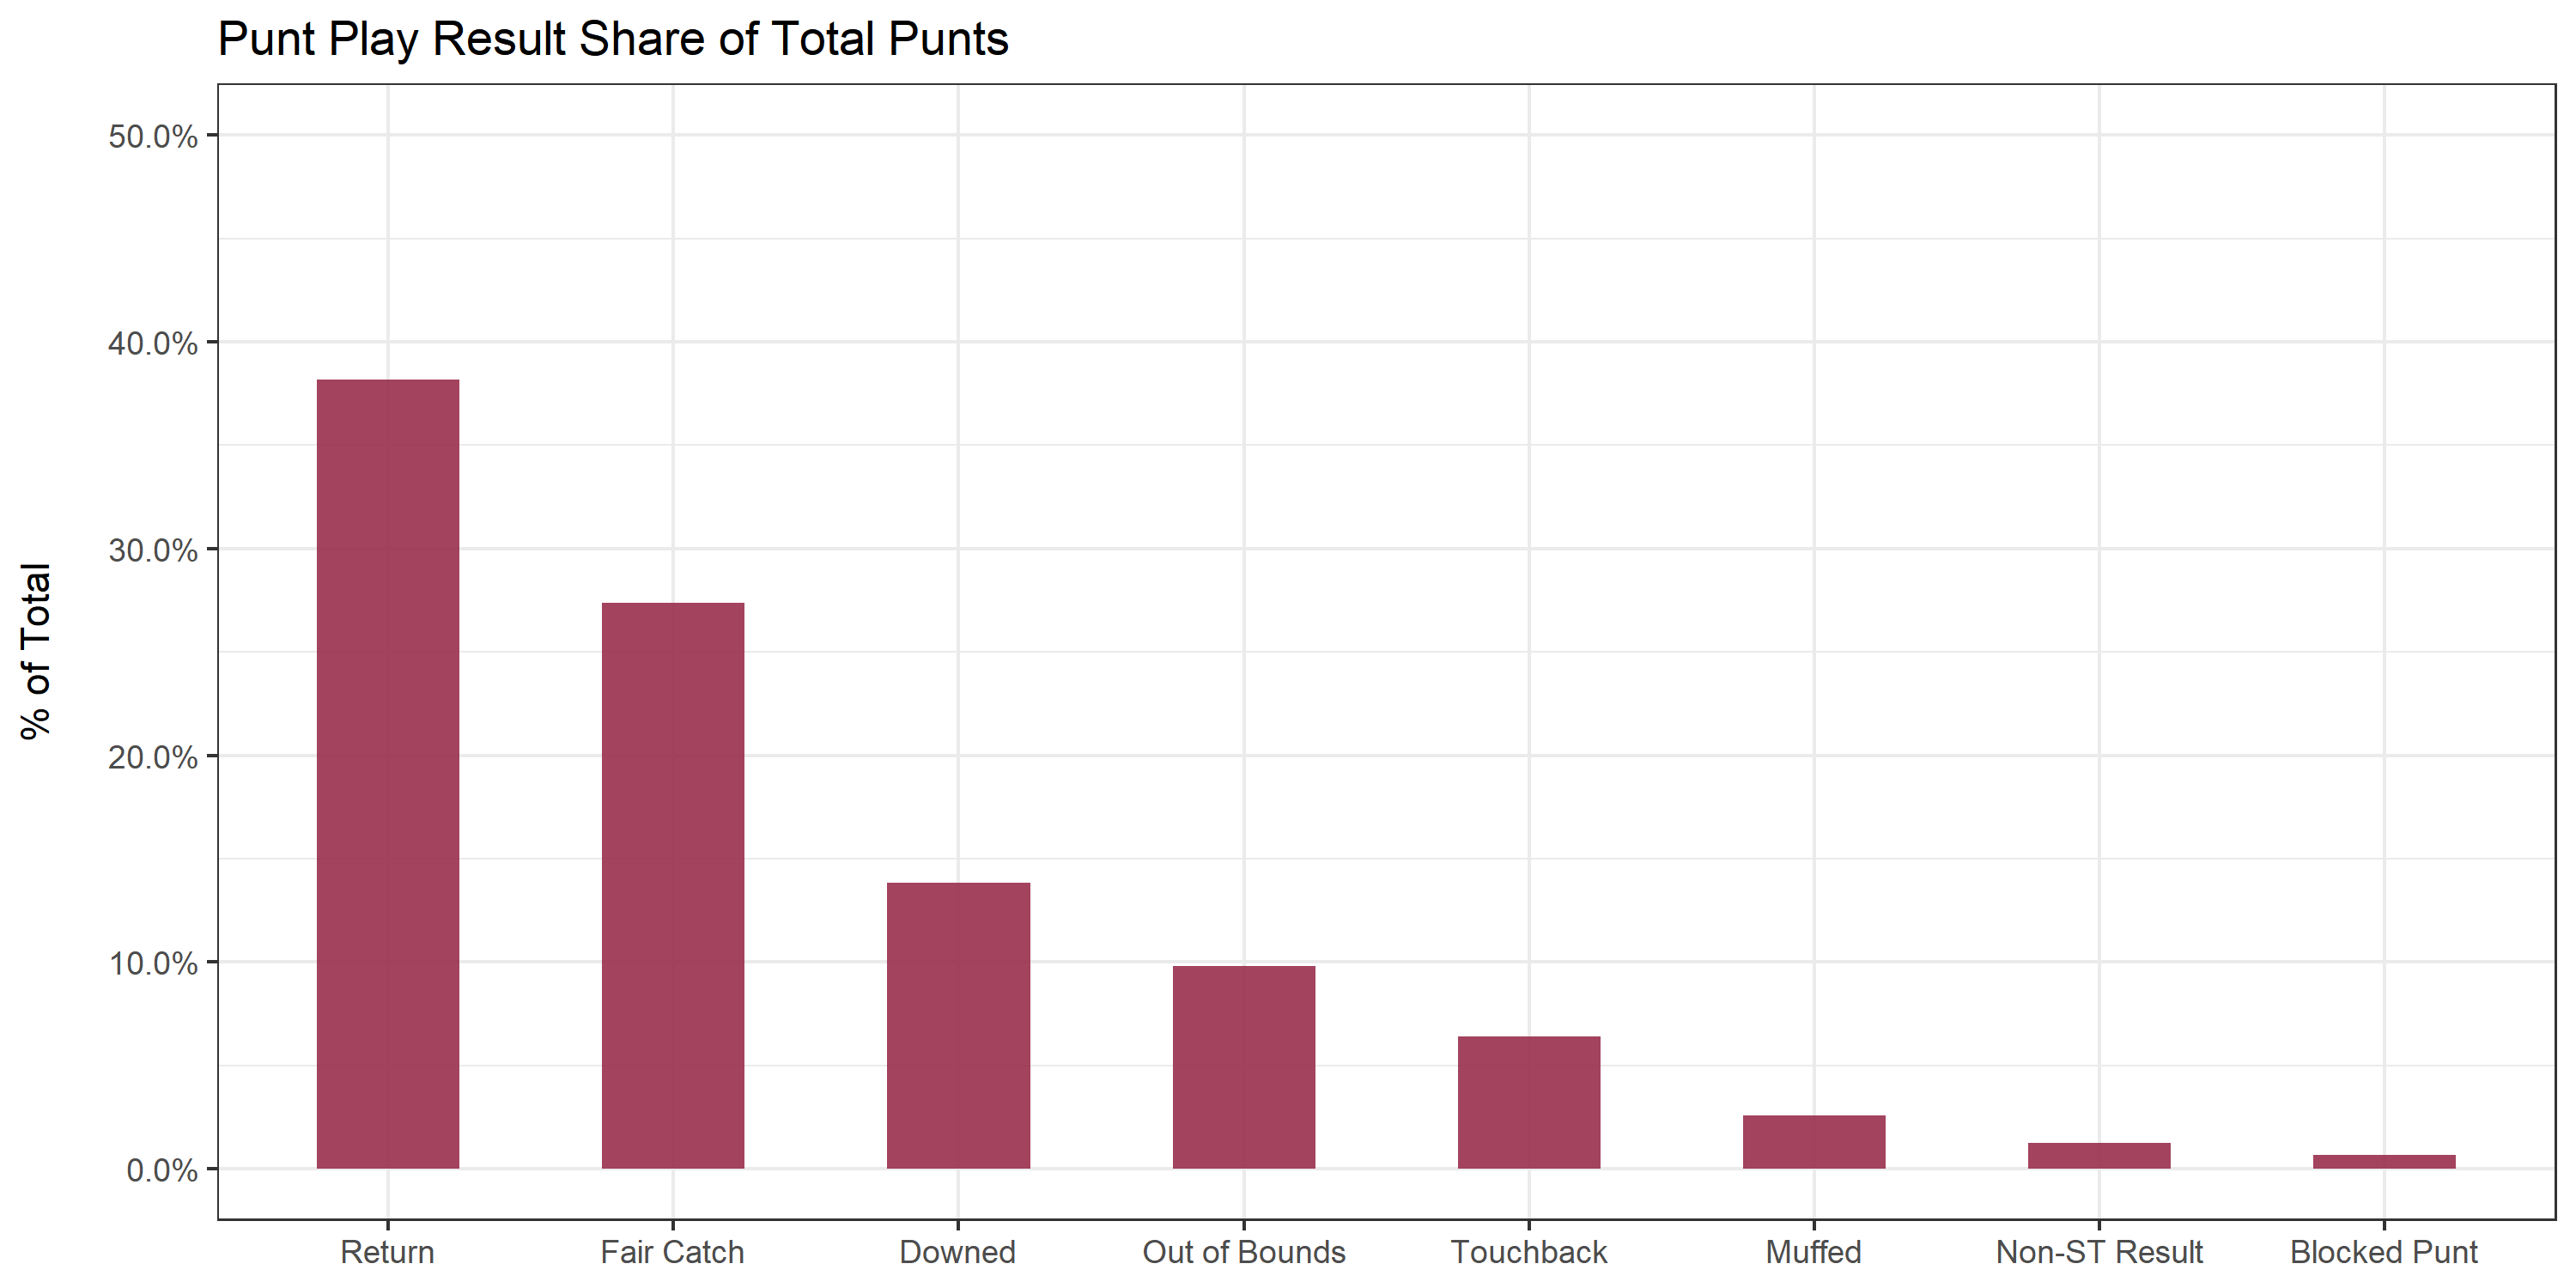
    
This analysis is comprised of three parts. First I create a metric titled **Return Yards Over Expected**, which measures the skill of punt returners when they decide to return the punt. Next, I create a version of RYOE that includes other punt play results such as touchbacks and fair catches, but adjusts the expected return yards in order to create a more realistic *hypothetical* expectation for those punt play decisions. Lastly, I attempt to quantify decision making on punt plays by creating a metric that is calculated by weighting the adjusted RYOE by how unexpected the decision was.

# Return Yards Over Expected

The first step to evaluating punt play decisions is to choose a metric by which to evaluate punt returns in general. Since Return Yards is the ultimate goal of any punt return, it is the obvious choice. **Return Yards Over Expected** utilizes the common methodology of comparing observed and expected values of a metric and is a more fair (and ideally more predictive) method of evaluation than raw Return Yards.

To calculate RYOE, an `xgboost` model was built to calculate the **Expected Return Yards**. The data used for this model was filtered to include only the frame where the ball arrives at the punt returner and only plays where there was a return. Muffed punts and returns with a fumble were excluded. The features for the model are:

-   Frames since the kick (hang-time)

-   Returner x, y, speed, direction of movement

-   Nearest and 2nd Nearest defender distance to returner and speed

-   Voronoi area of returner

Situation variables such as time remaining and line of scrimmage, were evaluated but excluded.

Punts that were downed, where a fair catch was called, or that resulted in a touchback were excluded from training. The model was trained on the 2018 and 2019 data and validated using the 2020 data. The model's RMSE was 9.47 and the baseline RMSE was 9.83. (The baseline model is if the mean punt return yardage is used as the prediction).

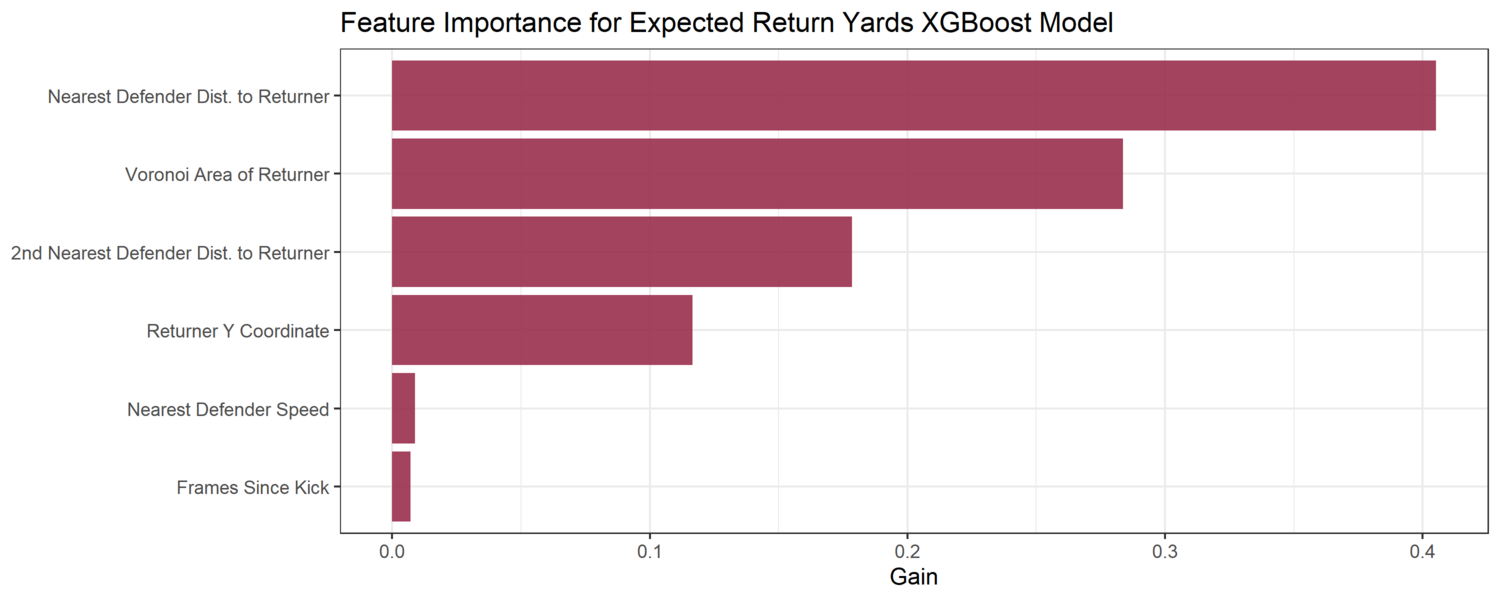

With Expected Return Yards now calculated, **Return Yards Over Expected** was calculated as the *actual return yards - expected return yards*. Using the model above, predictions were made for all plays that resulted in either a return, fair catch, touchback, or a downed punt. The predictions are calculated at the point of the catch or when punt hits the ground. The *actual* return yards for punts that were not returned were calculated as follows:

-   Fair catch: 0 yards

-   Downed punt: 0 - punt bounce distance (downfield distance from where the punt lands to where it is downed)

    -   *Calculating from the point where the punt lands assumes the ball could be caught and at least a fair catch was possible*

-   Touchback: 20 - punt land location

    -   *Calculating from the point where the punt lands assumes the ball could be caught and at least a fair catch was possible*

Below is the distribution of Return Yards Over Expected by punt result. The distributions follow what would be expected based on the definitions above. A notable observation, however, is how risky letting the ball drop could be. Also, RYOE for touchbacks is centered around 10, which means most touchbacks occur when the ball drops within the 10 yard line. 

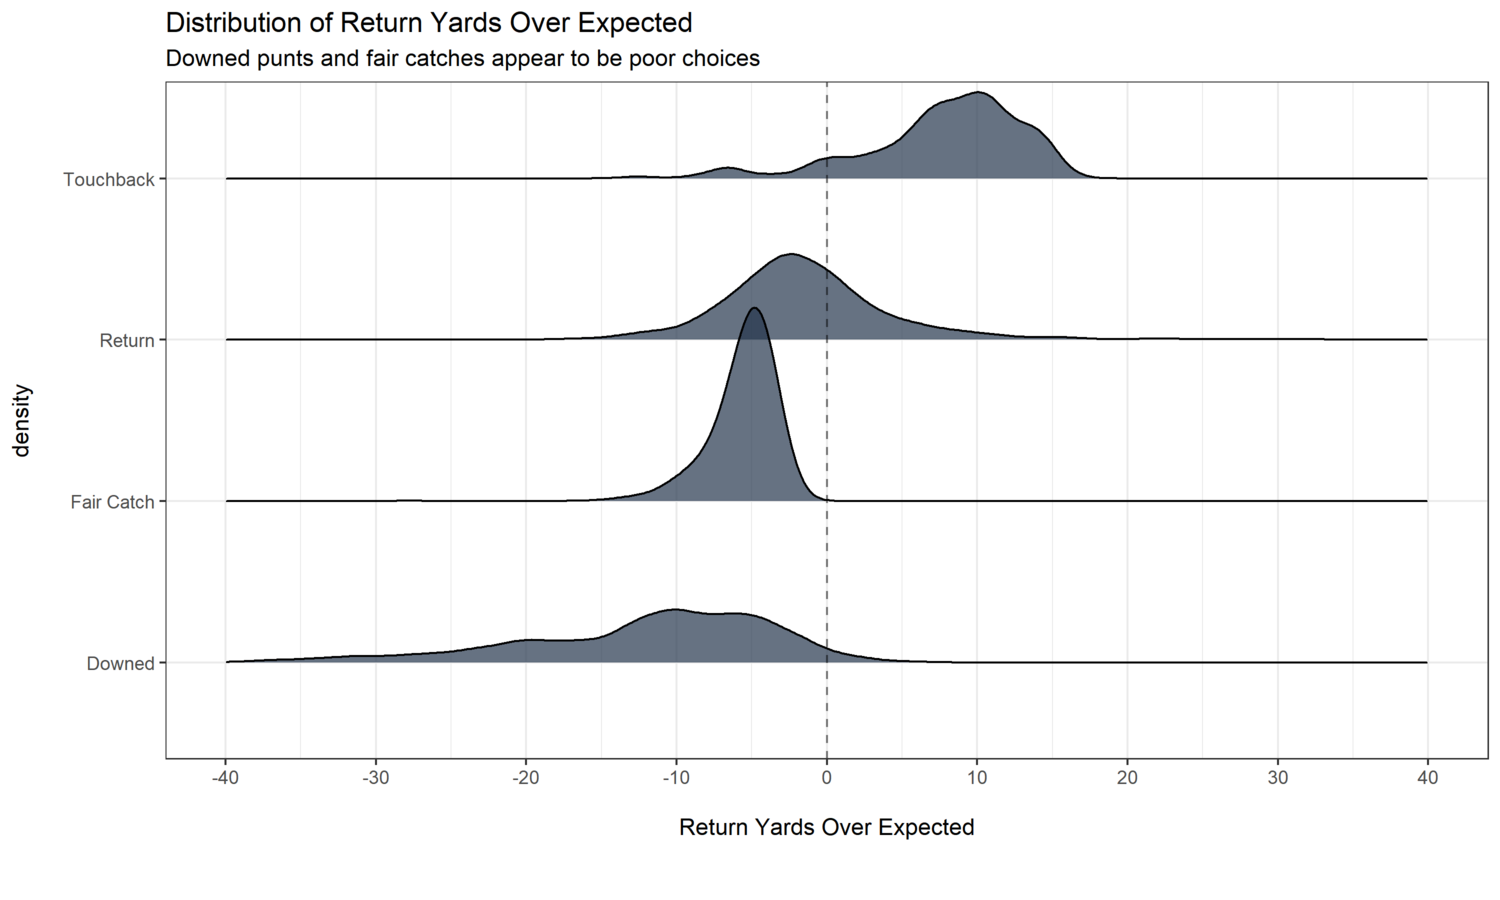

It is not necessarily fair, however, to make any conclusions from the information above. There might be situations where a fair catch or a downed punt is the appropriate decision so it may be incorrect, for example, to say fair catches are always bad. In those scenarios, the calculation for Expected Return Yards should be adjusted based on what the appropriate decision *should* be.

# Accounting for Decisions

**Adjusted Return Yards Over Expected** accounts for the decisions that have to be made on punt returns by adjusting the Expected Return Yards based on the probability of a return on the play.

> *Adjusted* Return Yards Over Expected = Actual Return Yards - (P( Return ) \* E[ Return Yards ])

This allows for a more fair evaluation of punts that were not returned since the expected return yards value should only be relevant if a return is likely. For example, if expected return yards is 10 but the returner called a fair catch, actual return yards would be 0 so RYOE would be -10. However, if there is only a 10% chance of the punt being returned, the expected return yards would be adjusted to 1 instead of 10. Therefore, the Adjusted Return Yards Over Expected (RYOE<sub>adj</sub>) would be -1.

Punt decision probabilities are calculated using an `xgboost` model that classifies observations into 4 punt result classes: returned, fair catch, downed, and touchback. The data was filtered to include only frames where the ball was the air until one second before it was caught/landed. The features for the model are:

-   Frames since the kick

-   Returner x, y, speed, acceleration, orientation, and direction of movement

-   Nearest and 2nd Nearest defender distance to returner, x and y locations, and speed

-   Voronoi area of returner

-   Returner distance to *expected* punt land/catch location

    -   This is calculated using two different `xgboost` models to predict x and y location of the punt land/catch

The model was trained on the 2018 and 2019 data and validated using the 2020 data. The model's Log-Loss was 1.13 and the baseline Log-Loss was 1.37. (The baseline model is if the proportion of total punts for each decision is used as the prediction). The probabilities used for adjusting RYOE are the average P(Return) throughout the frames where the ball was in the air until one second before it was caught/landed.

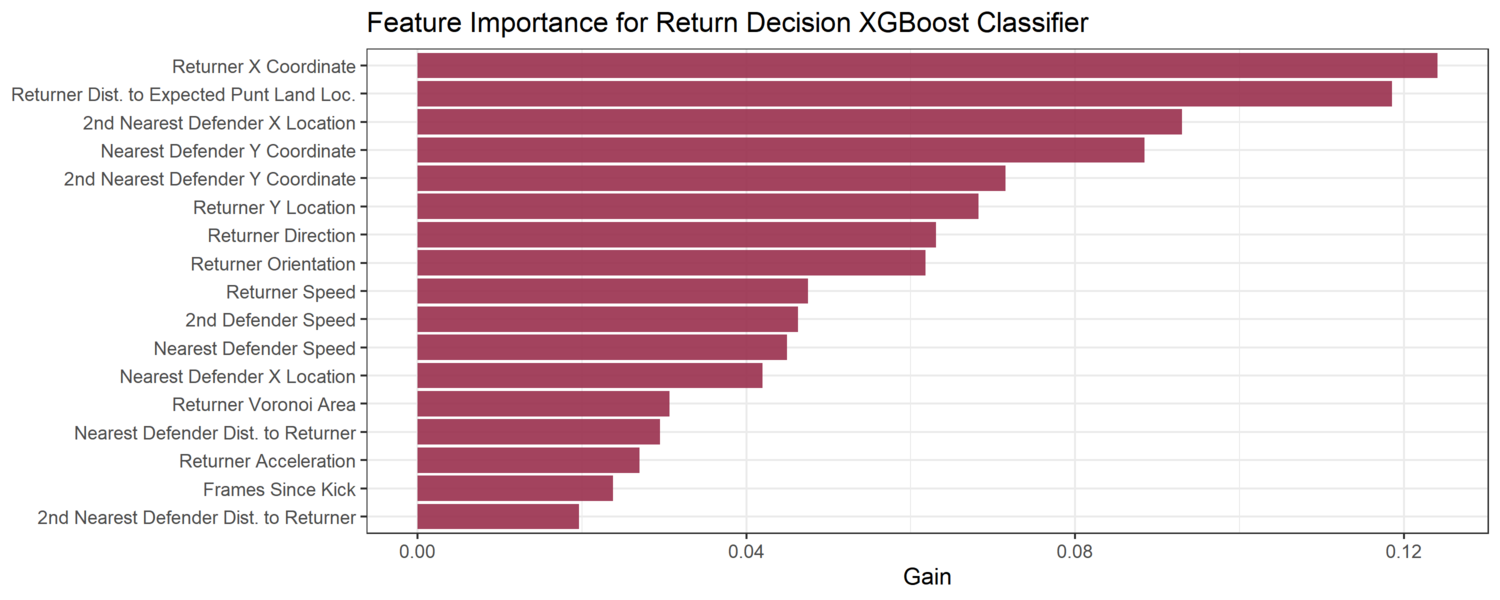

The plot below shows the distributions of Return Yards Over Expected and Adjusted Return Yards Over Expected. Not much changed for Returns, but for the other three decision types the adjusted version of Return Yards Over Expected is much higher than the non-adjusted values. The four punt return decisions can be classified as follows:

-   Returns - moderate risk, low-moderate reward

-   Fair Catches - minimal risk, no reward

-   Downed punts and Touchbacks - high risk for a long bounce, high reward if it's a touchback

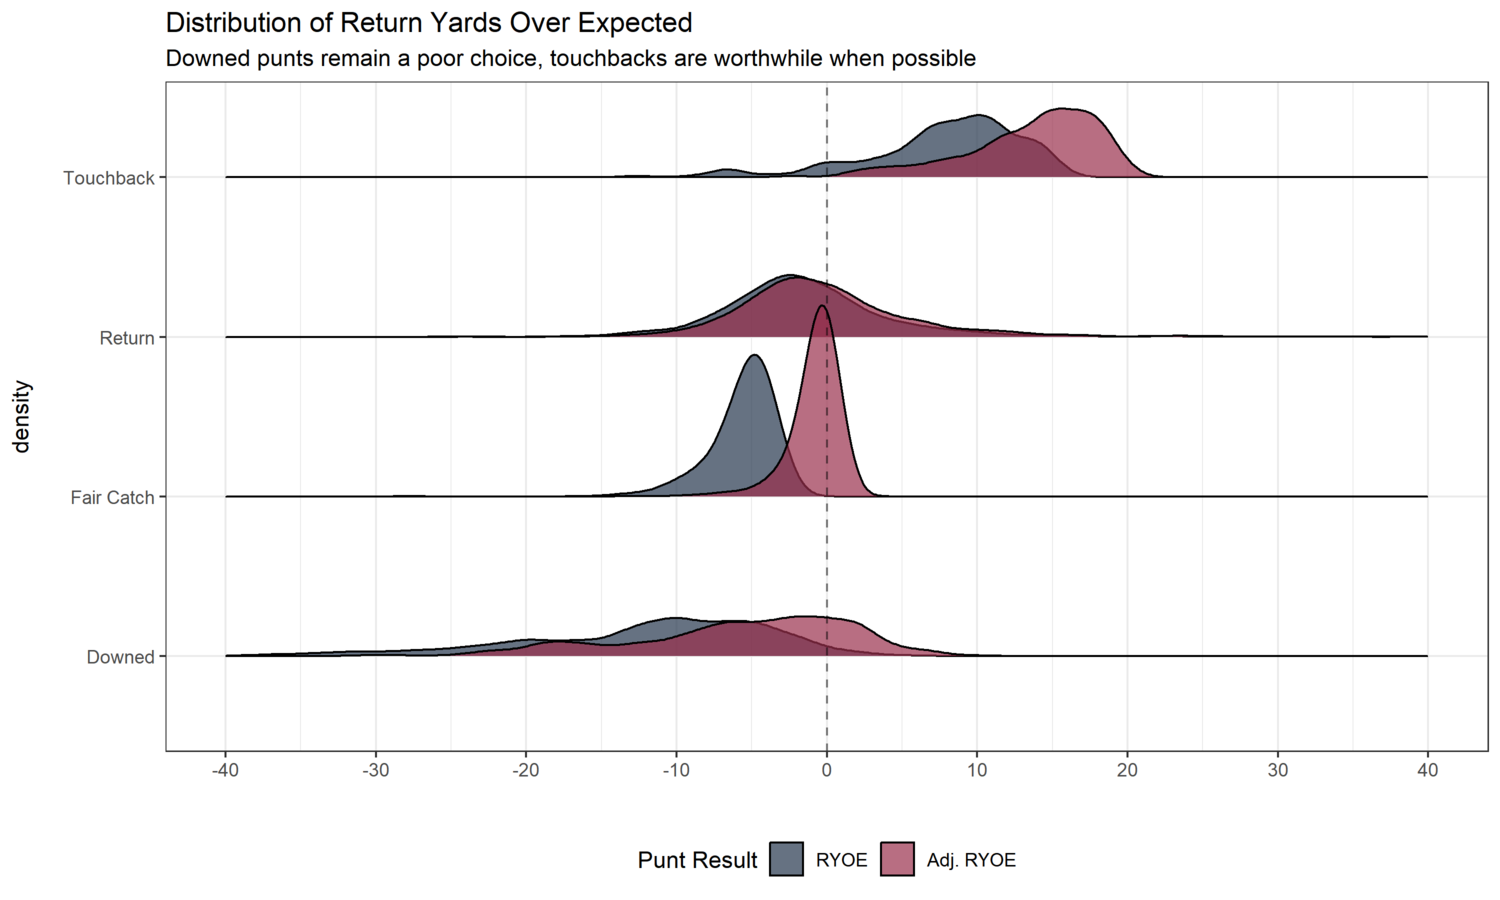

# Quantifying Decisions

With Return Yards Over Expected now adjusted to account for decision making, the last step is to quantify the decisions themselves. Quantifying decisions is complicated in most sports since a large portion of "skill" in professional sports is based on athletic ability. In football, decisions such as whether to pass or run the ball, or whether to go for it on fourth down have been analyzed in depth based on comparisons of win probability or EPA, but those are not useful outcomes for this analysis. EPA and win probability work well as metrics due to their interpretability. Unfortunately, it is difficult to find a metric that will correspond directly to the decisions on field during punt plays and be interpretable. However, we can use some combination of the probabilities for punt play decisions and Adjusted Return Yards Over Expected to create a proxy for decision making value. As mentioned earlier, RYOE<sub>adj</sub> adjusts for all possible punt play results where the returner would have control over the decision to return the punt. Therefore, it is useful for the evaluation of punts that were not returned.

The resulting metric, **Decision Weighted Return Yards Over Expected** (**dRYOE**), is the returner's Adjusted Return Yards Over Expected weighted by how "unexpected" the decision was. The exact calculation is:

> *Decision Weighted* Return Yards Over Expected = (1 - P(Decision)) \* RYOE<sub>adj</sub>

For example, on a play with RYOE<sub>adj</sub> of 15 where the returner chose to let the ball drop for a touchback, but P(Touchback) was 90%, the dRYOE would be 15 \* 0.1, or 1.5. RYOE<sub>adj</sub> gives a lot of credit for touchbacks and penalizes players heavily for downed punts. dRYOE is more fair since it shows how much credit the player truly deserves by taking into account how likely they are to make that decision.

# Future Work
Future improvements to this framework could include more interpretable methods for punt return probability, computer vision techniques for more accuracte expected return yards, and extrapolation of Return Yards Over Expected to EPA or Win Probability. 

# Summary

In this analysis I created three metrics:

1.  Return Yards Over Expected

    -   This measures returner skill on returning punts.

2.  Adjusted Return Yards Over Expected

    -   This is a more comprehensive measure of punt return value that attributes value to other types of punt play decisions.

3.  Decision Weighted Return Yards Over Expected

    -   This serves as a proxy to quantify the value of punt play decisions made by punt returners.  
    
Below is a summary of all metrics for qualifying players. 

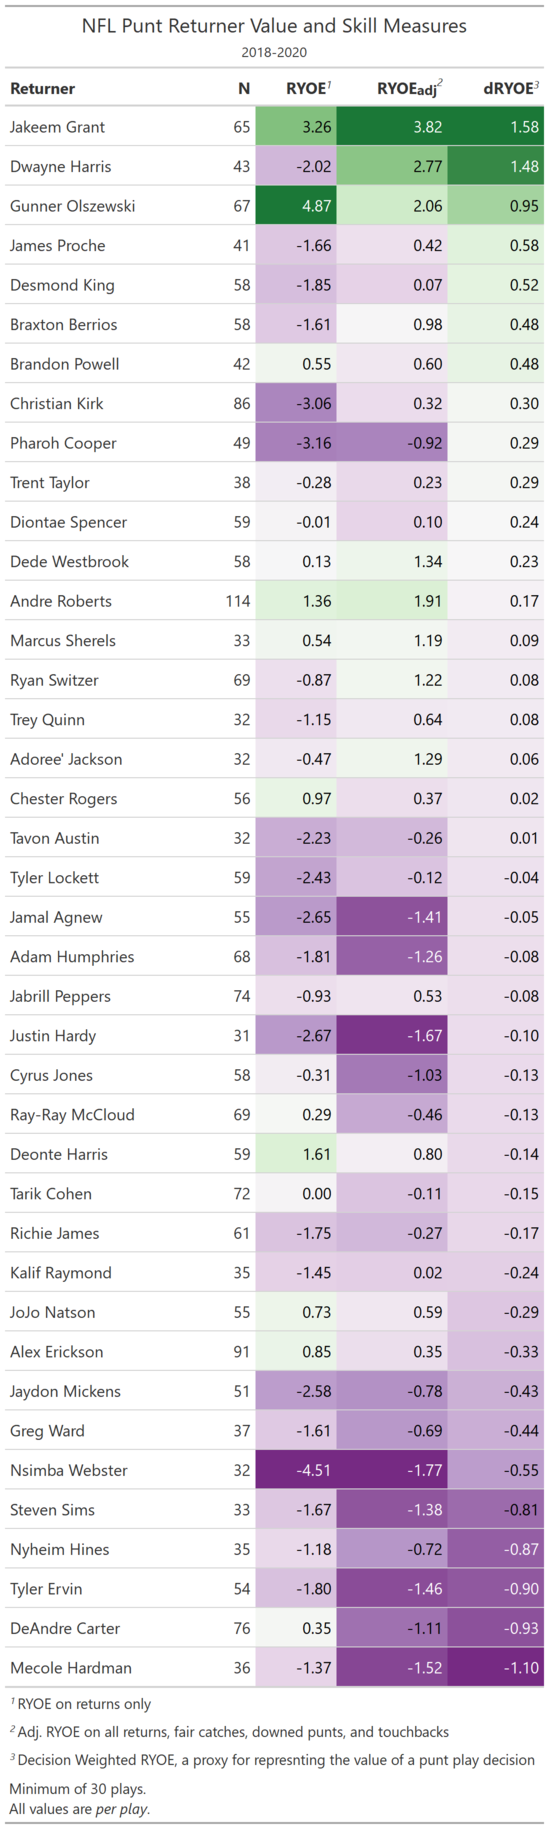

While athletic ability is generally the main focus of evaluation for most aspects of football, punt plays offer a strategy component that is at least equally as important. This is further augmented by the lack of stability for all the metrics I attempted to create in this work. None of the three metrics presented above are stable from year to year at the player or team level. Other metrics I attempted to create that were not presented were also not stable. The challenge with punt returns is that the punt return personnel changes often from year to year and there are not many players with a qualifying number of punt plays in all three years. Therefore, evaluating punt returner skill is descriptive, not predictive. What is predictive, is the value of punt play decisions in general. Returns offer a chance at high RYOE but on average they under-perform and are not that much more valuable, and more risky, than fair catches. Letting the ball bounce offers the chance at a touchback, but doing so in front of the 10 yard line almost always results in a large loss of yardage. While we cannot necessarily determine which players should be chosen as a punt returner based on these metrics, it is clear that teams that avoid downed punts will be putting themselves in better positions to win.


Dani Treisman | DePaul University  
[Project Code](https://github.com/dtreisman/BigDataBowl22)  
[Twitter](https://twitter.com/DaniTreisman)  
[LinkedIn](https://www.linkedin.com/in/dani-treisman/)  
[Other Projects](https://dtreisman.github.io/Portfolio/)


